In [243]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

%matplotlib inline
pd.set_option('display.max_columns', 64)
pd.set_option('display.max_rows', 100)

def isnan(num):
    return num != num

In [244]:
homePath = 'game'
trainPath = os.path.join(homePath, 'train_precessing.csv')
trainData = pd.read_csv(trainPath)
testPath = os.path.join(homePath, 'test_precessing.csv')
testData = pd.read_csv(testPath)

In [245]:
len(trainData)

679208

In [246]:
trainData = pd.concat([trainData, testData], axis=0, ignore_index=False).reset_index()

In [247]:
fullData = trainData.copy()

In [248]:
del fullData['member_id']
del fullData['mths_since_last_major_derog']
del fullData['annual_inc_joint']
del fullData['dti_joint']
del fullData['verification_status_joint']
del fullData['tot_coll_amt']
del fullData['tot_cur_bal']
del fullData['open_acc_6m']
del fullData['open_il_6m']
del fullData['open_il_12m']
del fullData['open_il_24m']
del fullData['mths_since_rcnt_il']
del fullData['total_bal_il']
del fullData['il_util']
del fullData['open_rv_12m']
del fullData['open_rv_24m']
del fullData['max_bal_bc']
del fullData['all_util']
del fullData['total_rev_hi_lim']
del fullData['inq_fi']
del fullData['total_cu_tl']
del fullData['inq_last_12m']
del fullData['emp_title']
del fullData['mths_since_last_record']
del fullData['emp_length']
del fullData['acc_now_delinq']

In [249]:
fullData['annual_inc'].fillna(-9999, inplace=True)
fullData['pub_rec'].fillna(-9999, inplace=True)
fullData['revol_bal'].fillna(-9999, inplace=True)
fullData['revol_util'].fillna(-9999, inplace=True)
fullData['total_acc'].fillna(-9999, inplace=True)
fullData['collections_12_mths_ex_med'].fillna(-9999, inplace=True)

In [250]:
trainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856684 entries, 0 to 856683
Data columns (total 64 columns):
index                          856684 non-null int64
acc_now_delinq                 679208 non-null float64
addr_state                     856684 non-null int64
all_util                       20612 non-null float64
annual_inc                     856680 non-null float64
annual_inc_joint               489 non-null float64
application_type               856684 non-null int64
collection_recovery_fee        856684 non-null float64
collections_12_mths_ex_med     856544 non-null float64
dti                            856684 non-null float64
dti_joint                      488 non-null float64
earliest_cr_line               856684 non-null int64
emp_length                     813373 non-null float64
emp_title                      806973 non-null float64
funded_amnt                    856684 non-null float64
funded_amnt_inv                856684 non-null float64
grade                   

# 预测 tot_cur_bal

In [251]:
local = np.where(np.array(trainData['tot_cur_bal'] >= 0))
totLabel = trainData['tot_cur_bal'].loc[local]
totTrain = fullData.loc[local]

[1]	valid_0's l2: 2.24634e+10	valid_0's auc: 0.660753
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 2.13699e+10	valid_0's auc: 0.679386
[3]	valid_0's l2: 2.03949e+10	valid_0's auc: 0.677269
[4]	valid_0's l2: 1.94965e+10	valid_0's auc: 0.678139
[5]	valid_0's l2: 1.86759e+10	valid_0's auc: 0.678917
[6]	valid_0's l2: 1.79397e+10	valid_0's auc: 0.682691
[7]	valid_0's l2: 1.74029e+10	valid_0's auc: 0.698192
[8]	valid_0's l2: 1.67916e+10	valid_0's auc: 0.700421
[9]	valid_0's l2: 1.62316e+10	valid_0's auc: 0.697951
[10]	valid_0's l2: 1.57194e+10	valid_0's auc: 0.698291
[11]	valid_0's l2: 1.52515e+10	valid_0's auc: 0.698109
[12]	valid_0's l2: 1.48261e+10	valid_0's auc: 0.698283
[13]	valid_0's l2: 1.4518e+10	valid_0's auc: 0.702493
[14]	valid_0's l2: 1.41589e+10	valid_0's auc: 0.702391
[15]	valid_0's l2: 1.38357e+10	valid_0's auc: 0.703186
[16]	valid_0's l2: 1.35946e+10	valid_0's auc: 0.705628
[17]	valid_0's l2: 1.33746e+10	valid_0's auc: 0.708782
[18]	valid_0's

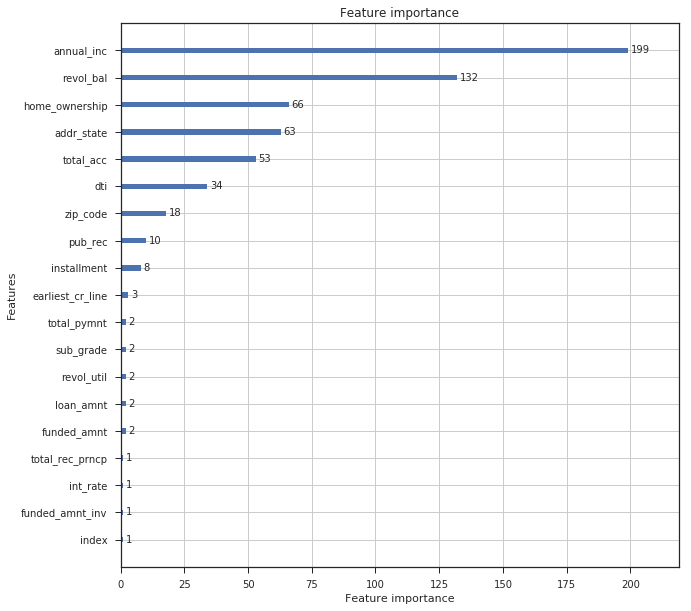

In [252]:
import lightgbm as lgb

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'auc'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

lgb_train = lgb.Dataset(totTrain[:400000], totLabel[:400000])
lgb_eval = lgb.Dataset(totTrain[400000:], totLabel[400000:])
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)
lgb.plot_importance(gbm, figsize=(10,10))

In [253]:
upFeatures = ['annual_inc', 'revol_bal', 'addr_state', 'home_ownership', 'total_acc', 'dti']
totTrain = totTrain[upFeatures]
totTest = trainData.loc[(trainData['tot_cur_bal'].isnull())][upFeatures]
totTest['total_acc'].fillna(-9999, inplace=True)
totTest['annual_inc'].fillna(-9999, inplace=True)

In [254]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(totTrain)
train_d = ss.transform(totTrain)
test_d = ss.transform(totTest)

In [255]:
from sklearn import linear_model
lin = linear_model.BayesianRidge()
lin.fit(train_d, totLabel)
trainData.loc[(trainData['tot_cur_bal'].isnull()), 'tot_cur_bal'] = lin.predict(test_d)

# 处理 revol_util

In [256]:
trainData['revol_util'].fillna(trainData['revol_util'].median(), inplace=True)

# 预测 total_rev_hi_lim

In [257]:
local = np.where(np.array(trainData['total_rev_hi_lim'] >= 0))
totLabel = trainData['total_rev_hi_lim'].loc[local]
totTrain = fullData.loc[local]

[1]	valid_0's l2: 1.22821e+09	valid_0's auc: 0.542136
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 1.14852e+09	valid_0's auc: 0.534181
[3]	valid_0's l2: 1.1235e+09	valid_0's auc: 0.603078
[4]	valid_0's l2: 1.05364e+09	valid_0's auc: 0.596583
[5]	valid_0's l2: 9.9004e+08	valid_0's auc: 0.597253
[6]	valid_0's l2: 9.12483e+08	valid_0's auc: 0.592327
[7]	valid_0's l2: 8.46547e+08	valid_0's auc: 0.590339
[8]	valid_0's l2: 8.0047e+08	valid_0's auc: 0.588761
Early stopping, best iteration is:
[3]	valid_0's l2: 1.1235e+09	valid_0's auc: 0.603078


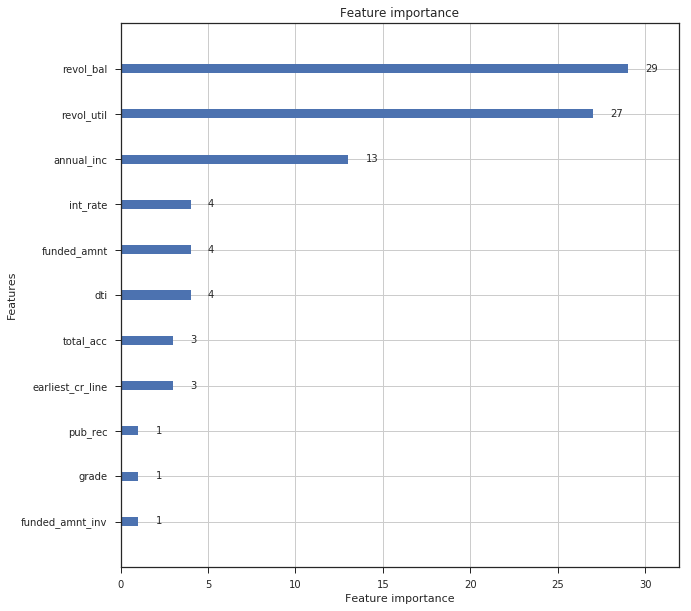

In [258]:
import lightgbm as lgb

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'auc'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

lgb_train = lgb.Dataset(totTrain[:400000], totLabel[:400000])
lgb_eval = lgb.Dataset(totTrain[400000:], totLabel[400000:])
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)
lgb.plot_importance(gbm, figsize=(10,10))

In [259]:
upFeatures = ['revol_util', 'revol_bal', 'annual_inc']
totTrain = totTrain[upFeatures]
totTest = trainData.loc[(trainData['total_rev_hi_lim'].isnull())][upFeatures]
totTest['annual_inc'].fillna(-9999, inplace=True)

In [260]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(totTrain)
train_d = ss.transform(totTrain)
test_d = ss.transform(totTest)

In [261]:
from sklearn import linear_model
lin = linear_model.BayesianRidge()
lin.fit(train_d, totLabel)
trainData.loc[(trainData['total_rev_hi_lim'].isnull()), 'total_rev_hi_lim'] = lin.predict(test_d)

# 处理 earliest_cr_line

In [262]:
trainData['earliest_cr_line'] = trainData['earliest_cr_line'] - 1900010
trainData['earliest_cr_line'] /= 10

In [263]:
# 暂时不做处理

# 处理 total_acc

In [264]:
trainData['total_acc'].fillna(trainData['total_acc'].median(), inplace=True)

# 预测 mths_since_last_major_derog

In [265]:
local = np.where(np.array(trainData['mths_since_last_major_derog'] >= 0))
totLabel = trainData['mths_since_last_major_derog'].loc[local]
totTrain = fullData.loc[local]

[1]	valid_0's l2: 488.898	valid_0's auc: 0.624304
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 486.865	valid_0's auc: 0.621729
[3]	valid_0's l2: 485.142	valid_0's auc: 0.609088
[4]	valid_0's l2: 483.491	valid_0's auc: 0.610206
[5]	valid_0's l2: 482.139	valid_0's auc: 0.612809
[6]	valid_0's l2: 481.326	valid_0's auc: 0.61562
Early stopping, best iteration is:
[1]	valid_0's l2: 488.898	valid_0's auc: 0.624304


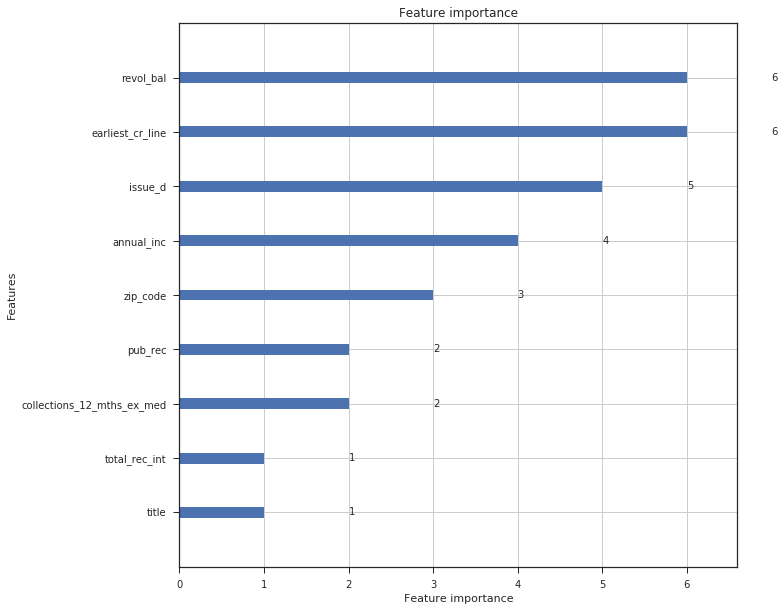

In [266]:
import lightgbm as lgb

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'auc'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

lgb_train = lgb.Dataset(totTrain[:100000], totLabel[:100000])
lgb_eval = lgb.Dataset(totTrain[100000:], totLabel[100000:])
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)
lgb.plot_importance(gbm, figsize=(10,10))

In [267]:
# 'total_acc', 
upFeatures = ['revol_bal', 'annual_inc', 'earliest_cr_line']
totTrain = totTrain[upFeatures]
totTest = trainData.loc[(trainData['mths_since_last_major_derog'].isnull())][upFeatures]
totTest['annual_inc'].fillna(-9999, inplace=True)

In [268]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(totTrain)
train_d = ss.transform(totTrain)
test_d = ss.transform(totTest)

In [269]:
from sklearn import linear_model
lin = linear_model.BayesianRidge()
lin.fit(train_d, totLabel)
trainData.loc[(trainData['mths_since_last_major_derog'].isnull()), 'mths_since_last_major_derog'] = lin.predict(test_d)

# 预测 mths_since_last_record

In [270]:
local = np.where(np.array(trainData['mths_since_last_record'] >= 0))
totLabel = trainData['mths_since_last_record'].loc[local]
totTrain = fullData.loc[local]

[1]	valid_0's l2: 766.54	valid_0's auc: 0.997242
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 746.665	valid_0's auc: 0.996851
[3]	valid_0's l2: 729.096	valid_0's auc: 0.996558
[4]	valid_0's l2: 712.934	valid_0's auc: 0.996538
[5]	valid_0's l2: 699.602	valid_0's auc: 0.996634
[6]	valid_0's l2: 692.129	valid_0's auc: 0.996868
Early stopping, best iteration is:
[1]	valid_0's l2: 766.54	valid_0's auc: 0.997242


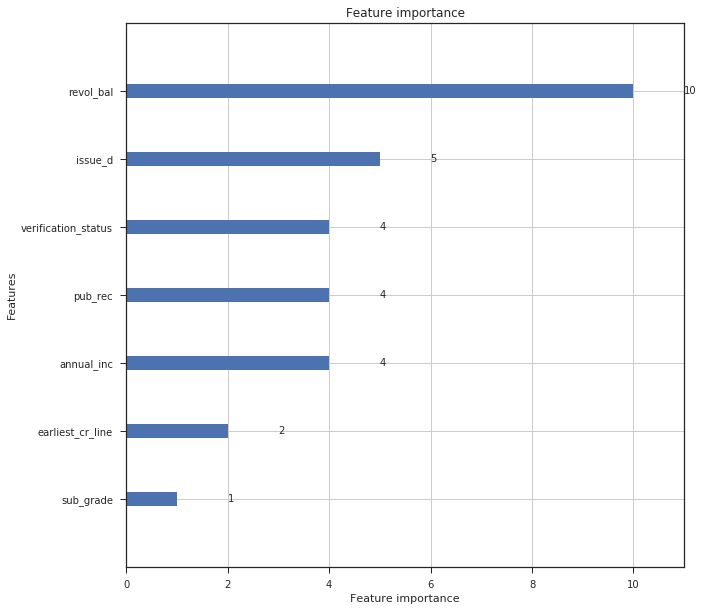

In [271]:
import lightgbm as lgb

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'auc'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

lgb_train = lgb.Dataset(totTrain[:70000], totLabel[:70000])
lgb_eval = lgb.Dataset(totTrain[70000:], totLabel[70000:])
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)
lgb.plot_importance(gbm, figsize=(10,10))

In [272]:
upFeatures = ['total_acc', 'revol_bal', 'pub_rec', 'earliest_cr_line', 'verification_status']
totTrain = totTrain[upFeatures]
totTest = trainData.loc[(trainData['mths_since_last_record'].isnull())][upFeatures]
totTest['pub_rec'].fillna(-9999, inplace=True)

In [273]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(totTrain)
train_d = ss.transform(totTrain)
test_d = ss.transform(totTest)

In [274]:
from sklearn import linear_model
lin = linear_model.BayesianRidge()
lin.fit(train_d, totLabel)
trainData.loc[(trainData['mths_since_last_record'].isnull()), 'mths_since_last_record'] = lin.predict(test_d)

# 预测 tot_coll_amt

In [275]:
local = np.where(np.array(trainData['tot_coll_amt'] >= 0))
totLabel = trainData['tot_coll_amt'].loc[local]
totTrain = fullData.loc[local]

[1]	valid_0's l2: 1.2046e+08	valid_0's auc: 0.633755
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 1.20457e+08	valid_0's auc: 0.636047
[3]	valid_0's l2: 1.20455e+08	valid_0's auc: 0.649718
[4]	valid_0's l2: 1.20453e+08	valid_0's auc: 0.651326
[5]	valid_0's l2: 1.20451e+08	valid_0's auc: 0.651837
[6]	valid_0's l2: 1.20449e+08	valid_0's auc: 0.654719
[7]	valid_0's l2: 1.20447e+08	valid_0's auc: 0.656412
[8]	valid_0's l2: 1.20444e+08	valid_0's auc: 0.654436
[9]	valid_0's l2: 1.20443e+08	valid_0's auc: 0.654891
[10]	valid_0's l2: 1.20441e+08	valid_0's auc: 0.655086
[11]	valid_0's l2: 1.2044e+08	valid_0's auc: 0.664182
[12]	valid_0's l2: 1.20438e+08	valid_0's auc: 0.666915
[13]	valid_0's l2: 1.20437e+08	valid_0's auc: 0.6669
[14]	valid_0's l2: 1.20436e+08	valid_0's auc: 0.668857
[15]	valid_0's l2: 1.20435e+08	valid_0's auc: 0.670438
[16]	valid_0's l2: 1.20434e+08	valid_0's auc: 0.670219
[17]	valid_0's l2: 1.20433e+08	valid_0's auc: 0.670141
[18]	valid_0's l2

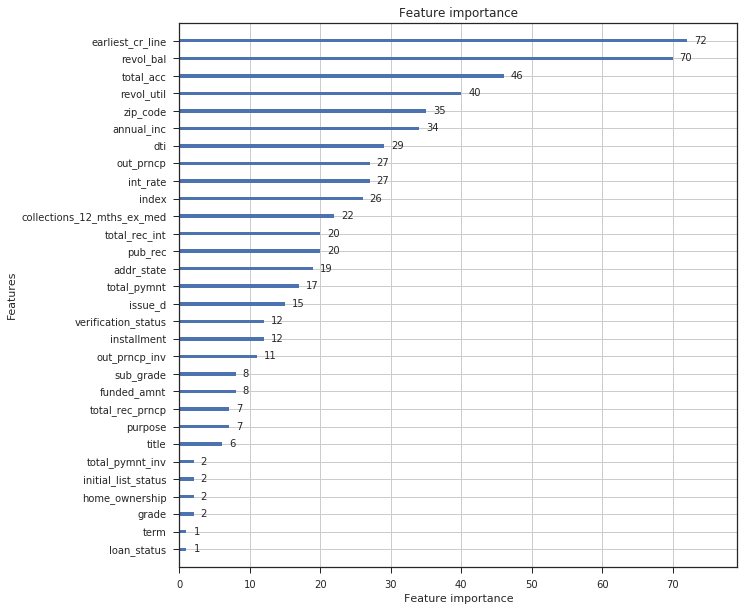

In [276]:
import lightgbm as lgb

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'auc'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

lgb_train = lgb.Dataset(totTrain[:70000], totLabel[:70000])
lgb_eval = lgb.Dataset(totTrain[70000:], totLabel[70000:])
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)
lgb.plot_importance(gbm, figsize=(10,10))

In [277]:
upFeatures = ['total_acc', 'revol_bal', 'revol_util', 'earliest_cr_line', 'annual_inc'] # , 'zip_code', 'annual_inc'
totTrain = totTrain[upFeatures]
totTest = trainData.loc[(trainData['tot_coll_amt'].isnull())][upFeatures]

In [278]:
totTest['annual_inc'].fillna(totTest['annual_inc'].mean(), inplace=True)

In [279]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(totTrain)
train_d = ss.transform(totTrain)
test_d = ss.transform(totTest)

In [280]:
from sklearn import linear_model
lin = linear_model.BayesianRidge()
lin.fit(train_d, totLabel)
# trainData.loc[(trainData['tot_coll_amt'].isnull()), 'tot_coll_amt'] = lin.predict(test_d)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)

# 预测 emp_title -暂不处理

# 分割特征

In [281]:
afterTestData = trainData[679208:]

In [282]:
trainData = trainData[:679208]

# 挑选特征

In [283]:
lgb_clf = lgb.LGBMClassifier(learning_rate=0.1,
                            boosting_type='gbdt',
                            objective='binary',
                            n_estimators=1000,
                            metric='auc',
                            max_depth=3,
                            num_leaves=5,
                            subsample=0.7,
                            colsample_bytree=0.7,
                            min_data_in_leaf=450,
                            feature_fraction=0.7,
                            bagging_fraction=0.7,
                            bagging_freq=6,
                            lambda_l1=1,
                            lambda_l2=0.001,
                            min_gain_to_split=0.265,
                            verbose=5,
                            is_unbalance=True,
                            random_state=10)


In [284]:
subTrain = trainData.copy()
subLabel = trainData['acc_now_delinq']

In [285]:
del subTrain['index']
del subTrain['member_id']
del subTrain['acc_now_delinq']

In [286]:
lgb_clf.fit(subTrain, subLabel)

LGBMClassifier(bagging_fraction=0.7, bagging_freq=6, boosting_type='gbdt',
        class_weight=None, colsample_bytree=0.7, feature_fraction=0.7,
        is_unbalance=True, lambda_l1=1, lambda_l2=0.001, learning_rate=0.1,
        max_depth=3, metric='auc', min_child_samples=20,
        min_child_weight=0.001, min_data_in_leaf=450,
        min_gain_to_split=0.265, min_split_gain=0.0, n_estimators=1000,
        n_jobs=-1, num_leaves=5, objective='binary', random_state=10,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.7,
        subsample_for_bin=200000, subsample_freq=1, verbose=5)

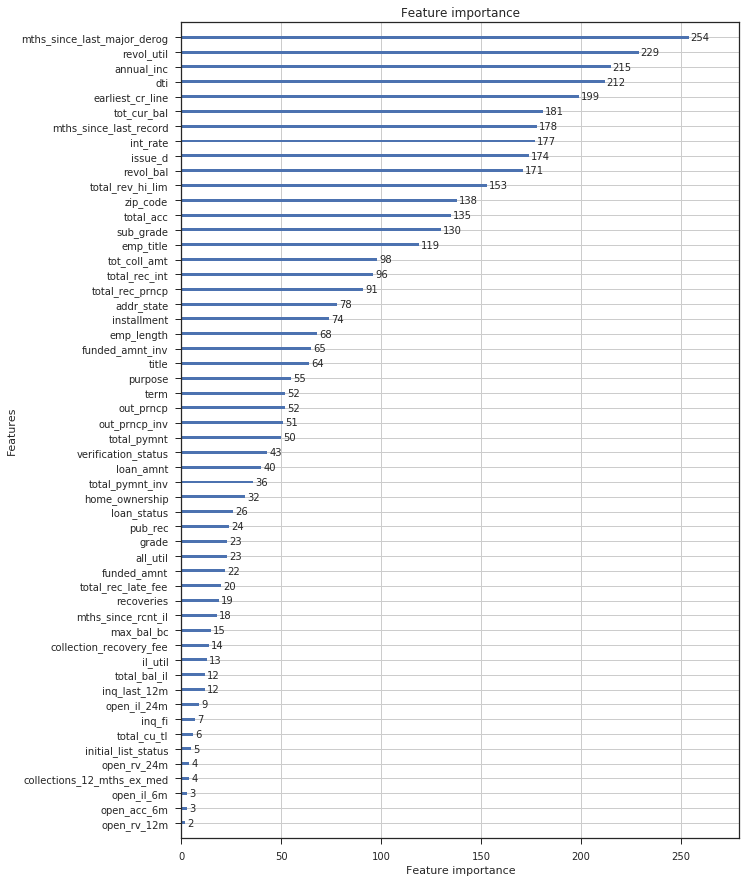

In [287]:
lgb.plot_importance(lgb_clf, figsize=(10,15))

In [288]:
ipt = pd.DataFrame()
ipt['feature_score'] = lgb_clf.feature_importances_
ipt['feature_name'] = subTrain.columns
after_sort = ipt.sort_index(by='feature_score', ascending=False)

/home/heolis/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  after removing the cwd from sys.path.


In [289]:
# 不填充 mths_since_last_record    mths_since_last_major_derog
# select_attributes = list(after_sort[:17]['feature_name'])
# test_out_no_fill = afterTestData[select_attributes]
# outPath_test = os.path.join(homePath, 'test_no_fill.csv')
# test_out_no_fill.to_csv(outPath_test, index=False)

# select_attributes.append("acc_now_delinq")
# train_out_no_fill = trainData[select_attributes]
# outPath_train = os.path.join(homePath, 'train_no_fill.csv')
# train_out_no_fill.to_csv(outPath_train, index=False)



In [290]:
# 填充
select_attributes = list(after_sort[:17]['feature_name'])
test_out_fill = afterTestData[select_attributes]
outPath_test = os.path.join(homePath, 'test_fill_t.csv')
test_out_fill.to_csv(outPath_test, index=False)

select_attributes.append("acc_now_delinq")
train_out_fill = trainData[select_attributes]
outPath_train = os.path.join(homePath, 'train_fill_t.csv')
train_out_fill.to_csv(outPath_train, index=False)

